In [39]:
from pylab import *
colormap='Greys_r'

cmap = cm.get_cmap(colormap, 55)
gcolors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    gcolors.append(matplotlib.colors.rgb2hex(rgb))
gcolors = np.array(gcolors)

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import os
from astropy import units as u
from tqdm import tqdm_notebook
from astropy import constants
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.nddata import CCDData
import ccdproc as ccdp
from astropy.time import Time
from matplotlib import gridspec
from scipy.io import readsav
from scipy.interpolate import interp1d
from scipy.ndimage import percentile_filter
from astropy import units
from scipy.stats import kendalltau, spearmanr

import starry
starry.config.lazy = False
starry.config.quiet = True

import warnings
warnings.filterwarnings("ignore")

datadir = '/Users/arcticfox/Downloads/gemini_data'

TIME = Time(np.load(os.path.join(datadir, 'mjddates.npy')), format='mjd')
barycorr = np.load(os.path.join(datadir, 'barycorr.npy')) * u.km / u.s

lines = Table.read(datadir + '_2021/fraunhofer.txt', format='ascii')
lines.add_row(['HeI', 587.5618, 587.5618, 16])

parula_colors = np.load('/Users/arcticfox/parula_colors.npy')

COLOR='k'
#COLOR = '#FFE8BF'
if COLOR == 'white' or COLOR == '#FFE8BF':
    ACCENT_COLOR = parula_colors[210]
else:
    ACCENT_COLOR = COLOR
    

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.major.size'] = 9

In [2]:
planet_d_per = 12.403200
planet_c_per = 8.249580

planet_c_dur = (4.66*u.hour).to(u.day).value
planet_d_dur = (5.59*u.hour).to(u.day).value

planet_c_t0 = 2458846.097156# - 2400000
planet_d_t0 = 2458845.803649# - 2400000

In [3]:
import batman 

def batman_model(time, vals):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = vals[0]                       #time of inferior conjunction
    params.per = vals[1]                       #orbital period
    params.rp = vals[2]                       #planet radius (in units of stellar radii)
    params.a = vals[3]                        #semi-major axis (in units of stellar radii)
    params.inc = 89.                     #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [vals[4], vals[5]]     #limb darkening coefficients [u1, u2, u3, u4]

    m = batman.TransitModel(params, time)    #initializes model
    return m.light_curve(params)

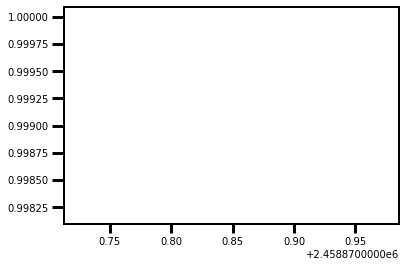

In [4]:
planetc_params_new = [2458846.097156, 8.24958, 0.0381, 13.19, 0.591, 0.098]
jdtime = Time(TIME, format='mjd').jd
battime = np.linspace(jdtime[0], jdtime[-1], len(jdtime))

c_lightcurve_new = batman_model(jdtime, planetc_params_new)
plt.plot(battime, c_lightcurve_new, 'wo')
yphase = np.zeros(len(c_lightcurve_new))


yphase[c_lightcurve_new==1.0] = np.nan


time_from_mid = (jdtime - (planet_c_t0+3*planet_c_per)) * units.day
time_from_mid = time_from_mid.to(units.hour)


out_args = np.where(np.isnan(yphase)==False)[0]
yphase[out_args] = np.linspace(0, 1.0, len(out_args))
#plt.plot(battime, yphase+0.5)

In [5]:
fitsfiles = np.sort([os.path.join(datadir, i) for i in os.listdir(datadir)
                     if i.endswith('.fits')])
#TIME = np.zeros(len(fitsfiles))

for i in range(1):
    hdu = fits.open(fitsfiles[i])
#    TIME[i] = hdu[0].header['MJDATE']
#    hdu.close()
    
#len(TIME), planet_c_t0+planet_c_per*3-planet_c_dur/2

In [6]:
np.array([107, 104, 101])/255

array([0.41960784, 0.40784314, 0.39607843])

In [7]:
def hex_to_rgb(h):
    if '#' in h:
        h = h.lstrip('#')   
    hlen = int(len(h))
    rgb = tuple(int(h[i:int(i+hlen/3)], 16) / 255.0 for i in range(0, hlen, int(hlen/3)))
    return rgb

In [9]:
wavefiles = np.sort([os.path.join(datadir, i) for i in os.listdir(datadir)
                     if 'wavelength_order_' in i and i.endswith('.npy')])
specfiles = np.sort([os.path.join(datadir, i) for i in os.listdir(datadir)
                     if 'spectra_order_' in i and i.endswith('.npy')])

In [13]:
specfile = np.load(os.path.join(datadir, 'interpolated_spectra_new.npy'))
wavefile = np.load(os.path.join(datadir, 'interpolated_wavelengths_new.npy'))
ofile = np.load(os.path.join(datadir, 'interpolated_orders.npy'))
efile = np.load(os.path.join(datadir, 'interpolated_errors.npy'))

In [14]:
wavelengths = {}
spectra = {}
interp_std = {}
for i in range(len(lines)):
    wdat = wavefile[:,lines['index'][i]]
    sdat = specfile[:,lines['index'][i]]
    edat = efile[:,lines['index'][i]]
    wavelengths[lines['line'][i]] = wdat 
    spectra[lines['line'][i]] = sdat
    interp_std[lines['line'][i]] = edat
#spectra = np.load('interp_1d_spectra.npy')

In [15]:
def subregions(location, w, offsets, offset_line, feature=None):
    global TIME

    whole_region = ((w>=location-offsets[0]) & 
                    (w<=location+offsets[1]))

    line = ((w[whole_region]>=location-offset_line[0]) & 
            (w[whole_region]<=location+offset_line[1]))

    
    if feature != 'na' and feature != 'mgb4':
        continuum = np.where((line==False))[0]
    elif feature == 'na':
        continuum = np.where( ( (w>=587.5)  & (w<=588.6) ) |
                              ( (w>=590.0)  & (w<=591) ) )[0]
    elif feature == 'mgb4':
        continuum = np.where( ( (w) ))
    
    params = {'location': location,
              'region': whole_region,
              'line': line,
              'continuum': continuum}
        
    return params

In [16]:
def measure_excess(wavelength, spectra, params, tab):
    global TIME, out_args
    
    widths = np.zeros(len(TIME))

    #wave = wavelengths[:,tab['index'],:]
    #spec = spectra[:,tab['index'],:]
    
    lines = np.zeros((len(TIME), 
                      len(wavelength[0][params['region']])))#[params['line']])))
    waves = np.zeros((len(TIME), 
                      len(wavelength[0][params['region']])))#[params['line']])))
    new_spec = np.zeros((len(TIME),
                        len(wavelength[0][params['region']])))
    
    for i in range(len(TIME)):

        w, f = wavelength[i][params['region']]+0.0, spectra[i][params['region']]+0.0
        
        interp = np.polyfit(w[params['line']==False],
                            f[params['line']==False], 
                            deg=2)
        model = np.poly1d(interp)

        new_spec[i] = f / model(w)
        
    template_out = np.nanmedian(new_spec[out_args], axis=0)

    for i in range(len(new_spec)):
        ## CALCULATE EXCESS ABSORPTION
        divout = new_spec[i]/template_out
        mask = np.where(divout < np.nanmedian(divout)+2.5*np.nanstd(divout))[0]
        widths[i] = np.nansum((new_spec[i][mask]/template_out[mask]) - 1) * -1       
        lines[i] = new_spec[i]#[params['line']]
        waves[i] = wavelength[i][params['region']]#[params['line']]
        plt.plot(w[mask], new_spec[i][mask], 'k')
        
        #plt.plot(w[mask][params['line']], f[mask][params['line']])
        
    plt.plot(w, template_out, 'w')
    plt.axvspan(w[params['line']][0], w[params['line']][-1], 
                    color='darkorange', alpha=0.3)
    plt.title(tab['line'])
    #plt.axvspan(w[params['continuum']][0], w[params['continuum']][-1], 
    #                color='skyblue', alpha=0.4, zorder=1)
    print(w[mask][0], w[mask][-1])
    plt.ylim(np.nanmin(f[mask])-0.01, 
             np.nanmax(new_spec[i][mask])+0.01)
    plt.show()
    
    return widths, lines, waves

- sodium as doublet as a single feature (✓)
- Mg lines (x)
- h-beta line (x)
- FeII - 546.6 (✓)
- Li - 680.3 (✓)
- He - 587.5618

"\nax1.spines['right'].set_visible(False)\nax1.spines['top'].set_visible(False)\nax2.spines['right'].set_visible(False)\nax2.spines['top'].set_visible(False)\nax3.spines['right'].set_visible(False)\nax3.spines['top'].set_visible(False)\n"

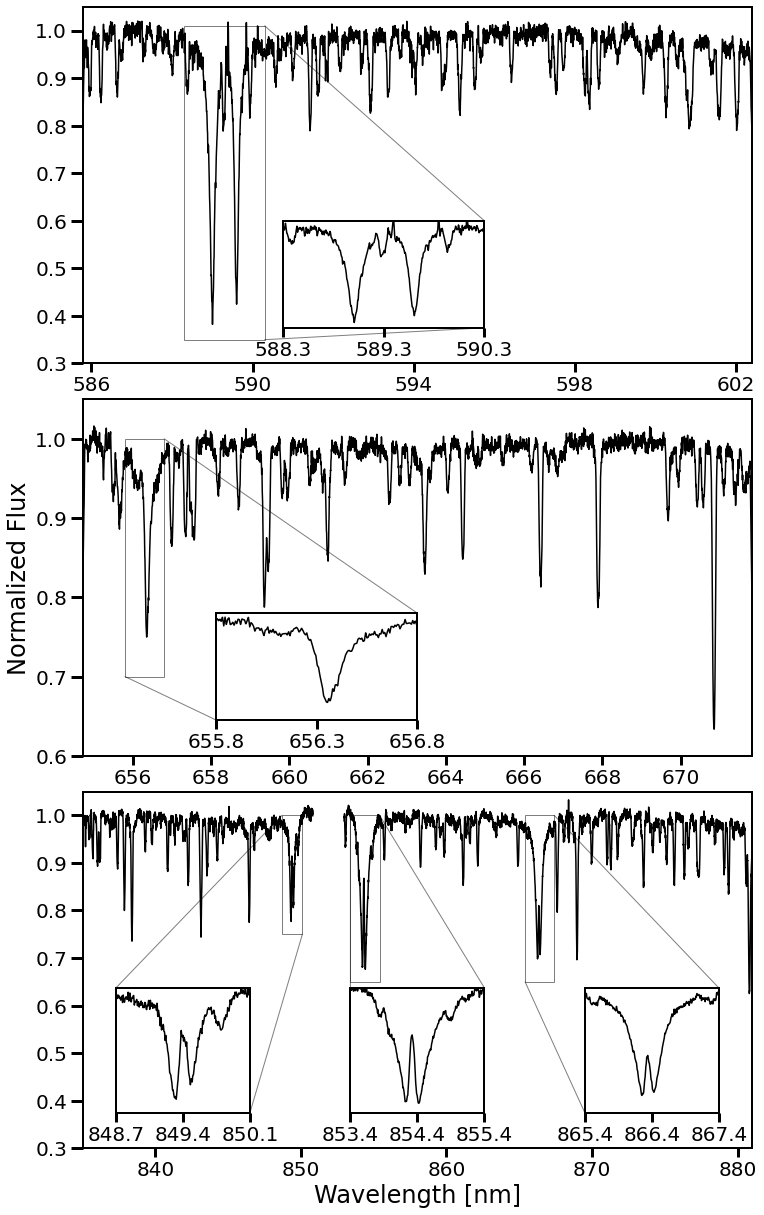

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12,21))
fig.set_facecolor('w')

hind = 20
ax2.plot(wavelengths['halpha'][hind], spectra['halpha'][hind], ACCENT_COLOR)
ax2.set_xlim(wavelengths['halpha'][hind][10], wavelengths['halpha'][hind][-10])

ax5 = ax2.inset_axes([0.2, 0.1, 0.3, 0.3])
ax5.plot(wavelengths['halpha'][hind], spectra['halpha'][hind], ACCENT_COLOR)
offset1 = 0.5
center1 = 656.3
ax5.set_xlim(center1-offset1,center1+offset1)
ax5.set_xticks([center1-offset1, center1, center1+offset1])
ax5.set_yticks([])
ax5.set_ylim(0.7, 1.0)
ax2.indicate_inset_zoom(ax5, edgecolor="black")


ax3.plot(wavelengths['caII'][15][10:], spectra['caII'][15][10:], ACCENT_COLOR)
ax3.plot(wavelengths['caI'][15], spectra['caI'][15], ACCENT_COLOR)
ax3.set_xlim(835,881)

ax7 = ax3.inset_axes([0.05, 0.1, 0.2, 0.35])
ax7.plot(wavelengths['caI'][15][10:], spectra['caI'][15][10:], ACCENT_COLOR)
offset1 = 0.7
center1 = 849.4
ax7.set_xlim(center1-offset1,center1+offset1)
ax7.set_xticks([center1-offset1, center1, center1+offset1])
ax7.set_ylim(0.75,1.0)

ax8 = ax3.inset_axes([0.4, 0.1, 0.2, 0.35])
ax8.plot(wavelengths['caII'][15][10:], spectra['caII'][15][10:], ACCENT_COLOR)
offset1 = 1.0
center1 = 854.4
ax8.set_xlim(center1-offset1,center1+offset1)
ax8.set_xticks([center1-offset1, center1, center1+offset1])
ax8.set_ylim(0.65,1.0)

ax9 = ax3.inset_axes([0.75, 0.1, 0.2, 0.35])
ax9.plot(wavelengths['caII'][15][10:], spectra['caII'][15][10:], ACCENT_COLOR)
offset1 = 1.0
center1 = 866.4
ax9.set_xlim(center1-offset1,center1+offset1)
ax9.set_xticks([center1-offset1, center1, center1+offset1])
ax9.set_ylim(0.65,1.0)

ax3.indicate_inset_zoom(ax7, edgecolor="black")
ax3.indicate_inset_zoom(ax8, edgecolor="black")
ax3.indicate_inset_zoom(ax9, edgecolor="black")

for ax in [ax7, ax8, ax9]:
    ax.set_yticks([])


nind = 51
q = spectra['NaD'][nind] < 1.02
ax1.plot(wavelengths['NaD'][nind][q], spectra['NaD'][nind][q], ACCENT_COLOR)
ax1.set_xlim(wavelengths['NaD'][nind][20], wavelengths['NaD'][nind][-10])
ax1.set_xticks(np.arange(586, 603, 4))

ax6 = ax1.inset_axes([0.3, 0.1, 0.3, 0.3])
ax6.plot(wavelengths['NaD'][nind][q], spectra['NaD'][nind][q], ACCENT_COLOR)
offset1 = 1.0
center1 = 589.3
ax6.set_xlim(center1-offset1,center1+offset1)
ax6.set_xticks([center1-offset1, center1, center1+offset1])
ax6.set_yticks([])
ax6.set_ylim(0.35, 1.01)
ax1.indicate_inset_zoom(ax6, edgecolor="black")

#ax4.plot(wavelengths['NaD'][nind][q], spectra['NaD'][nind][q], ACCENT_COLOR)
#ax4.set_xlim(588,590.7)

ax1.set_ylim(0.3,1.05)
ax2.set_ylim(0.6,1.05)
ax3.set_ylim(0.3,1.05)
plt.subplots_adjust(wspace=0.1)

ax2.set_ylabel('Normalized Flux', fontsize=24)
ax3.set_xlabel('Wavelength [nm]', fontsize=24)
plt.subplots_adjust(hspace=0.1)
"""
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
"""
#plt.savefig(os.path.join('/Users/arcticfox/Documents/atmospheres/v1298tau/figures/',
#                         'example_spectra.pdf'), 
#            rasterize=True, bbox_inches='tight',
#            dpi=300)

#plt.savefig('/Users/arcticfox/Desktop/example_spectra.png', 
#            rasterize=True, bbox_inches='tight',
#            dpi=300, transparent=True)

656.1012133077745 656.6488662070018


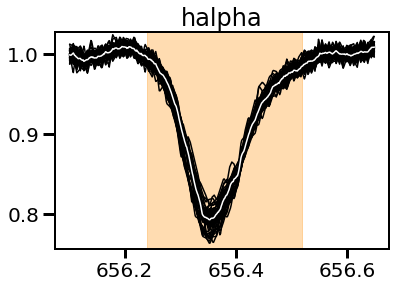

848.9000189757819 849.8980303334539


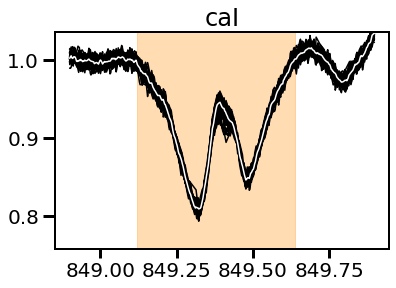

853.4009465894362 855.199754693927


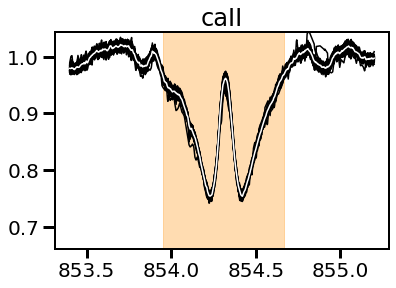

865.4017539434848 867.1983737169483


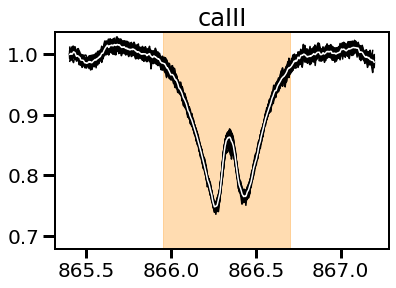

587.5004685015806 590.9996183874232


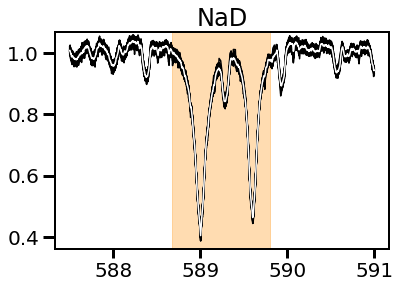

545.2508485931304 548.2492837271888


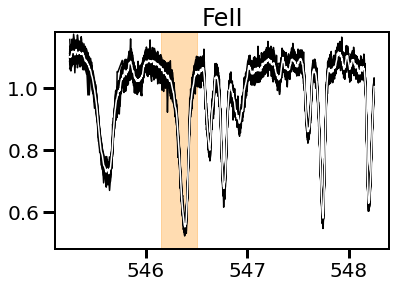

679.500306879512 680.2994887899681


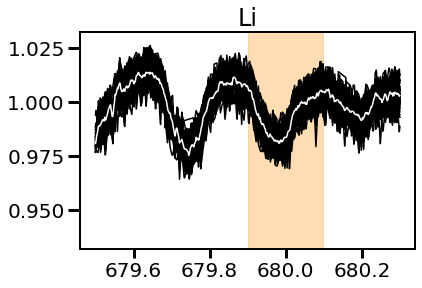

515.4009423745915 519.3988531758722


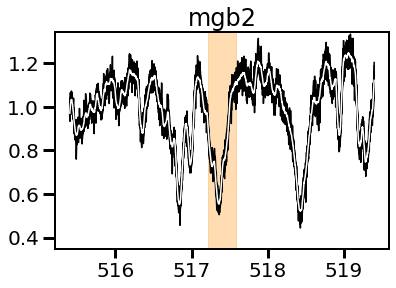

515.8003406040021 517.7999507558383


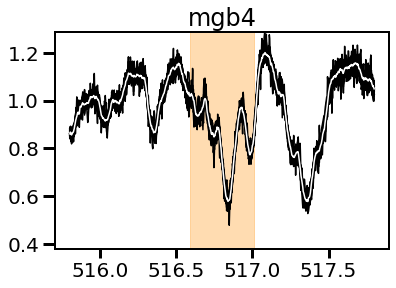

586.6502802896136 588.6494461484962


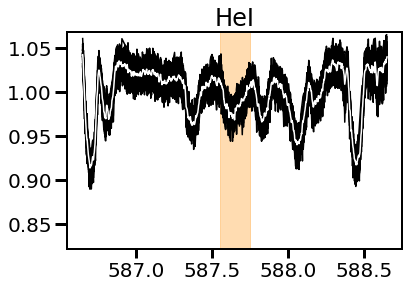

In [99]:
l = 3
offsets = [[0.25,0.3], 
           [0.5,0.5], 
           [0.9,0.9], 
           [0.9,0.9],
           [2,1.5], 
           [1,2], [0.5,0.3], [2,2],
           [1,1], [1,1], [0.5,0.5]]

line_offsets = [[0.11,0.17], 
                [0.28,0.24], 
                [0.35,0.37], 
                [0.35,0.4],
                [0.82,0.3], 
                [0.1,0.25], 
                [0.1,0.1], [0.18,0.18],
                [0.21,0.21], [0.1,0.1], [0.1,0.1]]
centers = [656.35, 849.4, 854.3, 866.3, 589.5, 546.25, 680.0, 517.4, 516.8, 587.65]
widths = {}
w_error = {}
ind_lines = {}
ind_waves = {}
all_params = {}

for l in range(len(lines)):
    key = lines['line'][l]
    params = subregions(centers[l],
                        wavelengths[key][0],
                        offsets[l], 
                        line_offsets[l], 
                        feature=key)
    all_params[key] = params 

    w, il, iw = measure_excess(wavelengths[key], spectra[key], 
                               params, lines[l])

    widths[lines['line'][l]] = w

    ind_lines[lines['line'][l]] = il
    ind_waves[lines['line'][l]] = iw

## Comparing to Veloce

In [21]:
from astropy.table import Column

In [22]:
table = Table.read('/Users/arcticfox/Documents/youngStars/veloce/spectra/updated_log.tab',
                   format='ascii')
table = table[table['overlapping']==0]
ages = np.zeros(len(table))
which_age = [25, 150, 150, 150, 25]
for i,t in enumerate(np.unique(table['TIC'])):
    args = np.where(table['TIC']==t)[0]
    ages[args] = which_age[i]
table.add_column(Column(ages, 'Ages_Myr'))

In [23]:
veloce_times = Time(table['time_mjd'], format='mjd')
len(veloce_times)

164

In [28]:

bins = np.arange(-12,12,1)
pink = '#c30758'
blue = parula_colors[80]

def plot_hist(ax, dat, bins, c, label, alpha=0.65, lw=2.5, histtype='step', zorder=0):
    ax.hist(dat, bins=bins,
            color=c, zorder=zorder,
            alpha=alpha, label=label)

    ax.hist(dat, bins=bins,
            edgecolor=c, fill=None, histtype=histtype,
            lw=lw, zorder=zorder)#, label=label)
    return

oc = gcolors[6]#parula_colors[10]#parula_colors[60]#'#e0db45'
vc = parula_colors[5]
yc = gcolors[1]#colors[1]#'#f2c708'#'#c30758'#

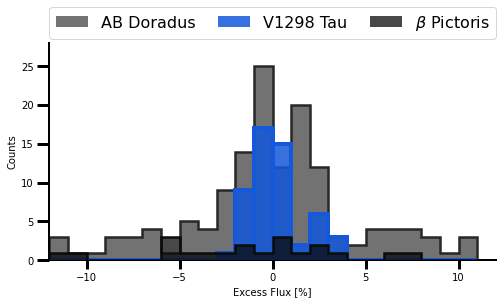

In [29]:
from scipy.stats import norm
old_tab = table[table['Ages_Myr']==150]
yng_tab = table[table['Ages_Myr']==25]
xd = np.linspace(-12,12,500)

fig, ax = plt.subplots(figsize=(8,4))

np.random.seed(124)

if COLOR == 'k':
    plot_hist(ax, old_tab['excess'],  bins, gcolors[7], 'AB Doradus', alpha=0.65,
          lw=2.5)
    plot_hist(ax, widths['halpha'],  bins, parula_colors[27], 'V1298 Tau', alpha=0.85,
          histtype='bar', lw=4, zorder=100)
    plot_hist(ax, yng_tab['excess'],  bins, gcolors[2], r'$\beta$ Pictoris', alpha=0.75,
              lw=2.5, zorder=200)
else:
    plot_hist(ax, old_tab['excess'],  bins, colors[5], 'AB Doradus', alpha=0.65,
          lw=2.5)
    plot_hist(ax, widths['halpha'],  bins, parula_colors[210], 'V1298 Tau', alpha=0.85,
          histtype='bar', lw=4, zorder=100)
    plot_hist(ax, yng_tab['excess'],  bins, colors[10], r'$\beta$ Pictoris', alpha=0.75,
              lw=2.5, zorder=200)

plt.xlim(-12,12)
plt.ylim(0,28)

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0., fontsize=16)
plt.xlabel('Excess Flux [%]')
plt.ylabel('Counts')

#plt.savefig(os.path.join(plot_dir,'veloce_diff.pdf'), dpi=200,
#            rasterize=True, bbox_inches='tight')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.savefig(os.path.join(github_dir,'veloce_diff.png'), dpi=200,
#            rasterize=True, bbox_inches='tight', transparent=True)

### To-Do List

- **do the same for the veloce data --> measure halpha emission in excess**
- **run elsa's star on one night**
- **run for the rest of the Fraunhofer lines** --> https://en.wikipedia.org/wiki/Fraunhofer_lines
- **e R r O r    B a R s**
    - OPERA pipeline error bars: what do they look like? (✓)
    - Estimate scatter around the line and take that as the uncertainty
- **Cool to do: combine the lines (straightforward in velocity space?)**

### To-Done List

- run for some telluric line and demonstrate we don't see the same thing (✓)
- do the same waterfall plot with just halpha (✓)
- normalize halpha depth to be the same (✓)
    - similar to what we did for veloce emission
- rerun without final 6 frames (✓)
- calcium triplet -- if it's flat we're good. if it isn't we need to fear the spot (✓)

In [50]:
from matplotlib.colors import LinearSegmentedColormap

clist = np.array(['#000000', parula_colors[60], '#FFFFFF'])
#clist = np.array(['#000000', '#026D95', '#FFFFFF'])
rgb_tuples = []

for c in clist:
    rgb_tuples.append(hex_to_rgb(c))

cm = LinearSegmentedColormap.from_list(
        'sequential', rgb_tuples, N=2048)

In [51]:
def expanding_bins(lines, repeat=3, subtract=True, med=None):
    global TIME
    
    if med is None and subtract==True:
        med = np.nanmedian(lines, axis=0)
    binned = np.zeros( (len(TIME)*repeat, len(lines[0]))  )
            
    z = 0
    for i in range(len(lines)):
        if subtract == True:
            binned[z:z+repeat] = lines[i] - med
        else:
            binned[z:z+repeat] = lines[i]
        z += repeat
    return binned

In [52]:
def normalizing_depth(wave, spectra, plot=False, reg=[655.6,655.75]):
    normalized = np.zeros(spectra.shape)
    
    if plot:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
    
    for i,flux in enumerate(spectra):
        
        region = ((wave[i]>=reg[0]) & (wave[i]<=reg[-1]))

        norm_around_zero = flux - np.nanmedian(flux[~region])
        area = np.trapz(norm_around_zero[region], wave[i][region])
        normalized[i] = norm_around_zero/np.abs(area)
        
        if plot:
            ax1.plot(wave[i], flux, c=parula_colors[i*4])
            ax2.plot(wave[i], norm_around_zero / np.abs(area),
                     c=parula_colors[i*4])
            
    if plot:
        plt.show()
    return normalized

In [53]:
halpha_normalized = normalizing_depth(ind_waves['halpha'], ind_lines['halpha'])

In [54]:
def to_velocity(wave, flux=None, line=None):
    if line != None:
        argmid = np.where(wave>=line)[0][0]
    else:
        argmid = int(len(wave)/2)
        if flux is not None:
            argmid = np.argmin(flux)
    lambda0 = wave[argmid] + 0.0
    rv_m_s = ((wave - lambda0)/lambda0 * 3e8)*units.m/units.s
    rv_km_s = rv_m_s.to(u.km/u.s)
    return rv_km_s, argmid

In [55]:
rv, _ = to_velocity(np.array([656.2102368016022, 656.5499844335302]), line=656.3)

In [56]:
lambda0 = 656.35
rv = np.array([656.2102368016022, 656.5499844335302])
val = ((rv - lambda0)/lambda0 * 3e8)*units.m/units.s
val.to(u.km/u.s)

<Quantity [-63.88201344,  91.40752656] km / s>

Text(0, 0.5, 'Normalized Spectra')

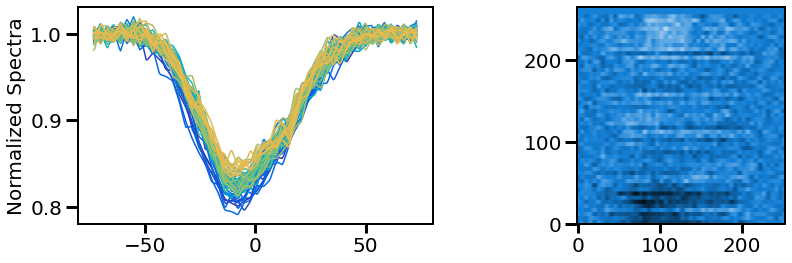

In [59]:
fig, ((ax3, ax1)) = plt.subplots(ncols=2, nrows=1, figsize=(14,4))
for i in range(2,len(ind_lines['halpha'])):
    vel,_ = to_velocity(ind_waves['halpha'][i])
    
    ax3.plot(vel, ind_lines['halpha'][i], c=parula_colors[i*4])
    ax4.plot(vel, halpha_normalized[i-2], c=parula_colors[i*4])

bins = expanding_bins(ind_lines['halpha'][2:], repeat=5)
ax1.imshow(bins, cmap=cm, vmin=-0.05, vmax=0.05)

bins = expanding_bins(halpha_normalized, repeat=5)
ax2.imshow(bins, cmap=cm, vmin=-1, vmax=1)

ax2.set_ylim(0,len(bins))
ax1.set_ylim(0,len(bins))
ax4.set_ylabel('Area-Normalized Spectra')
ax3.set_ylabel('Normalized Spectra')

#plt.savefig(os.path.join(plot_dir, 'halpha_compare.png'), dpi=200, rasterize=True,
#            bbox_inches='tight')

In [60]:
def mask_lines(w, s, std=2.5, offset=0.007, template_inds=None):

    if template_inds is None:
        template = np.zeros(len(s[0]))
    else:
        template = np.nanmedian(s[template_inds], axis=0)
    

    newwave = np.zeros((len(w), len(s[0])-1))
    newspectra = np.zeros((len(w), len(s[0])-1))
    
    for i in range(len(w)):
        
        deriv = 0.5*(np.diff(s[i]))
        mask = np.where( (deriv>=offset) | 
                         (deriv<=-offset) )

        masked_w, masked_s = w[i][1:]+0.0, s[i][1:]+0.0
        masked_w[mask] = np.nan
        masked_s[mask] = np.nan
        
        divout = masked_s/template[1:]
        mask = np.where(divout>np.nanmedian(divout)+std*np.nanstd(divout))
        masked_w[mask] = np.nan
        masked_s[mask] = np.nan
       #plt.plot(masked_w[mask], masked_s[mask], 'y.')
        
        newwave[i] = masked_w
        newspectra[i] = masked_s

    return newwave, newspectra

In [61]:
plot_dir = '/Users/arcticfox/Documents/atmospheres/v1298tau/figures/'

In [62]:
time_to_phase = interp1d(TIME.value, yphase)
phase_to_time = interp1d(yphase, TIME.value)

midtime = phase_to_time(0.5)
halfdur = planet_c_dur / 2.0
t1 = time_to_phase(midtime-halfdur)#, time_to_phase(midtime+halfdur)

ingress_time = (4.66-4.26)/2.0
egress_time = 4.66-ingress_time

interp_time = interp1d(np.linspace(0,4.66,len(yphase[np.isnan(yphase)==False])),
                       yphase[np.isnan(yphase)==False])
ingress_phase = interp_time(ingress_time)
egress_phase = interp_time(egress_time)

## emcee models

In [31]:
def load_emcee_files(direct, key):
    m = np.load(os.path.join(direct,'horus_models_{0}.npy'.format(key)))
    s = np.load(os.path.join(direct,'samples_{0}.npy'.format(key)))
    return m, s

def mcmc_subpanel(data, lim1, lim2, ax, models=[0], offset=0, 
                  c=parula_colors[0], medcolor=COLOR, alpha=0.3):
    q = ((data['vabsfine'][1:] > lim1) & (data['vabsfine'][1:]<lim2))
    
    ax.plot(data['vabsfine'][1:][q]+offset, data['avgprof'][q], medcolor, 
            lw=1.5, zorder=100)
    
    if len(models) > 1:

        for i in range(len(models)):
            ax.plot(data['vabsfine'][1:][q]+offset, models[i][1:][q], lw=1.5,
                    c=c, alpha=alpha, zorder=1)

In [32]:
dat1 = np.load('../misttborn/v1298_caI.pkl', allow_pickle=True)
m1, s1 = load_emcee_files('../misttborn/newwave/', 'caI')

dat2 = np.load('../misttborn/v1298_caII.pkl', allow_pickle=True)
m2, s2 = load_emcee_files('../misttborn/newwave/', 'caII')

dat3 = np.load('../misttborn/v1298_caIII.pkl', allow_pickle=True)
m3, s3 = load_emcee_files('../misttborn/newwave/', 'caIII')

In [33]:
nsamples = s1.shape[0]
last10 = int(nsamples-0.1*nsamples)
last50 = int(nsamples-0.5*nsamples)
last85 = int(nsamples-0.85*nsamples)

In [34]:
for i in range(17):
    print(np.nanstd(s1[last10:,:,i]), np.nanstd(s1[last50:,:,i]),np.nanstd(s1[last85:,:,i])) 

0.9485668105912334 1.0179635254690351 1.2644012768257529
0.0002074426840452026 0.00019003939475624836 0.00017509949483978215
22.826545013843454 17.539498225252135 14.994349523964553
0.10922271446132081 0.1098145771799138 0.10518454443233727
0.0006155894389140232 0.0004765670197360038 0.00038124414075329073
0.04859861139082449 0.03962091790719194 0.03293835506472308
1.2712614993331046 1.2565909060046991 1.212563608748931
0.2086780124305431 0.19570305437346933 0.1659621018082189
0.20187009436232783 0.19990144401155382 0.18223326463351738
0.210102228638458 0.18292430712260851 0.16535232608031478
0.29154590658084795 0.2653264624960797 0.24257724674767447
0.3326576652446056 0.31381874725617975 0.323524349952105
0.00018929057009480602 0.00017232751761143562 0.00014810085998059595
0.008778455085315615 0.008941950384352948 0.009618767423037057
2.1851095966051983 2.122481550463705 2.2075957874372754
1.8616124898412612 1.7933394353802086 1.811735669593587
0.0061442850967141265 0.0061899692236533

0
0.04291845493562235
0.5
0.9570815450643777
1
0
0.04291845493562235
0.5
0.9570815450643777
1
0
0.04291845493562235
0.5
0.9570815450643777
1


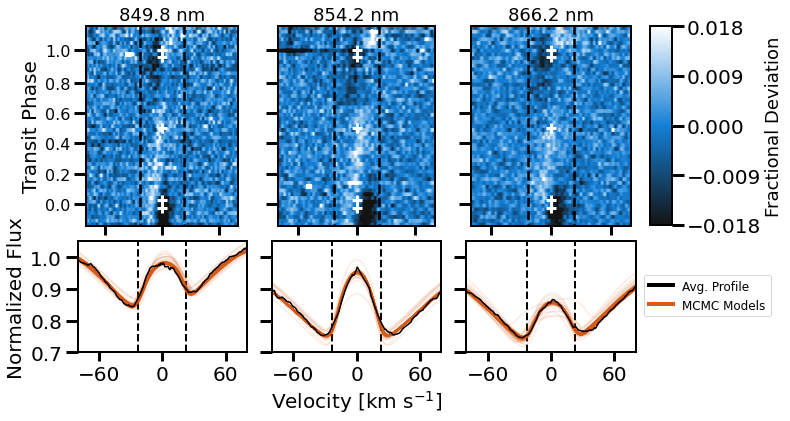

In [40]:
clist = np.array(['#141313', parula_colors[60], '#FFFFFF' ])

rgb_tuples = []

for c in clist:
    rgb_tuples.append(hex_to_rgb(c))

cm = LinearSegmentedColormap.from_list(
        'sequential', rgb_tuples, N=2048)


inds = np.arange(0,len(TIME)-6,4)

ratio=1.2
repeat = 5
keys = list(ind_lines.keys())[1:4]


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(figsize=(10,6),
                         ncols=len(keys), 
                         nrows=2, #sharec=True, 
                         gridspec_kw={'wspace':0.15,
                                      'hspace':0.1,
                                      'height_ratios':[1.8,1]})
fig.set_facecolor('w')
cbar_lim = 0.018

#i, x = 0, 0
for x, ax in enumerate([ax1, ax2, ax3]):
    
    nw, ns = mask_lines(ind_waves[keys[x]], ind_lines[keys[x]], 
                        std=6, offset=0.01,
                        template_inds=np.where(np.isnan(yphase)==True)[0])

    #template = np.nanmedian(ns[np.where(np.isnan(yphase)==True)], axis=0)
    bins = expanding_bins(ns, repeat=repeat)#, subtract=False)
    
    repeat_phase = np.zeros(len(yphase)*repeat)
    z = 0
    
    for i in range(len(TIME)):
        repeat_phase[z:z+repeat] = yphase[i]
        z += repeat
        
    interp_phase = interp1d(repeat_phase, np.arange(0,len(repeat_phase),1,dtype=int), )

    l = centers[x+1]
    if x == 2:
        l += 0.03
        
    vel, midpoint = to_velocity(nw[0], line=l)
    vel = vel.value

        
    interp = interp1d(vel, np.arange(0,len(vel),1))

    ax.set_title(keys[x], fontsize=20)
    #bins = expanding_bins(lines[x], repeat=4)
    im = ax.imshow(bins, cmap=cm,
                   vmin=-cbar_lim, vmax=cbar_lim)
    
    ax.vlines(interp(23), -10, len(bins+30), color='k', lw=2.5, linestyle='--')
    ax.vlines(interp(-23), -10, len(bins)+30, color='k', lw=2.5, linestyle='--')
    
    yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax.set_yticks(interp_phase(yticks))
    ax.set_yticklabels(yticks, fontsize=16)
    
    for p in [0, ingress_phase, 0.5, egress_phase, 1]:
        print(p)
        if p == 0:
            ax.plot(interp(0), interp_phase(p)-repeat, 'w+', ms=10, linewidth=4,
                markeredgecolor='w', markeredgewidth=3)
        else:
            ax.plot(interp(0), interp_phase(p), 'w+', ms=10, linewidth=4,
                    markeredgecolor='w', markeredgewidth=3)
    
    
    ax.set_ylim(0, len(bins))
    
    xticks = [-60,0,60]
    ax.set_xticks(interp(xticks))
    ax.set_xticklabels(xticks)
    ax.set_xlim(interp(-80), interp(80))
    
    if x == 0:
    #    ax.set_ylabel('Transit Phase', fontsize=20)
        ax.set_title('849.8 nm', fontsize=18)
    elif x == 1:
        ax.set_title('854.2 nm', fontsize=18)
        ax.set_yticklabels([])
    elif x == 2:
        ax.set_title('866.2 nm', fontsize=18)
        ax.set_yticklabels([])
    ax.set_xticklabels([])
    #x += 1
    
mcmc_subpanel(dat1, -100, 100, ax4, models=m1, c='#d65b14', 
              offset=-1.3,
              alpha=0.11)
mcmc_subpanel(dat2, -110, 100, ax5, models=m2, c='#d65b14', 
              offset=-7, alpha=0.11)
mcmc_subpanel(dat3, -100, 100, ax6, models=m3, c='#d65b14', 
              offset=-14, alpha=0.11)

ax6.plot(np.arange(200, 203, 1), np.arange(200, 203, 1), 'k', lw=4, label='Avg. Profile')
ax6.plot(np.arange(200, 203, 1), np.arange(200, 203, 1), '#d65b14', lw=4, label='MCMC Models')
ax6.legend(bbox_to_anchor=(1.05, 0.7), loc='upper left', borderaxespad=0.,
           fontsize=12)

for x, ax in enumerate([ax4, ax5, ax6]):
    ax.set_xlim(-80,80)
    ax.set_xticks([-60,0,60])
    ax.vlines(23, -10, len(bins+30), color='k', lw=2., linestyle='--', zorder=1)
    ax.vlines(-23, -10, len(bins)+30, color='k', lw=2.0, linestyle='--', zorder=1)
    ax.set_ylim(0.7, 1.05)
    ax.set_yticks([0.7, 0.8, 0.9, 1.0])
    if x > 0:
        ax.set_yticklabels([])

ax1.set_ylabel('Transit Phase')
ax4.set_ylabel('Normalized Flux')
ax5.set_xlabel('Velocity [km s$^{-1}$]', fontsize=20)    
cax = fig.add_axes([0.92, 0.42, 0.03, 0.46])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('Fractional Deviation', fontsize=18)
cbar.set_ticks(np.round(np.linspace(-cbar_lim, cbar_lim, 5),3))
#plt.savefig(os.path.join(plot_dir,
#                         'ca_deviations_mcmc.pdf'), 
#            rasterize=True, bbox_inches='tight', dpi=250)
#plt.savefig(os.path.join(github_dir,
#                         'ca_deviations_mcmc.png'), 
#            rasterize=True, bbox_inches='tight', dpi=250)

## No signal in different lines

In [63]:
from matplotlib.colors import LinearSegmentedColormap

clist = np.array(['#f5efec', '#4f4d4c'])
rgb_tuples = []

for c in clist:
    rgb_tuples.append(hex_to_rgb(c))

cmg = LinearSegmentedColormap.from_list(
        'sequential', rgb_tuples, N=2048)

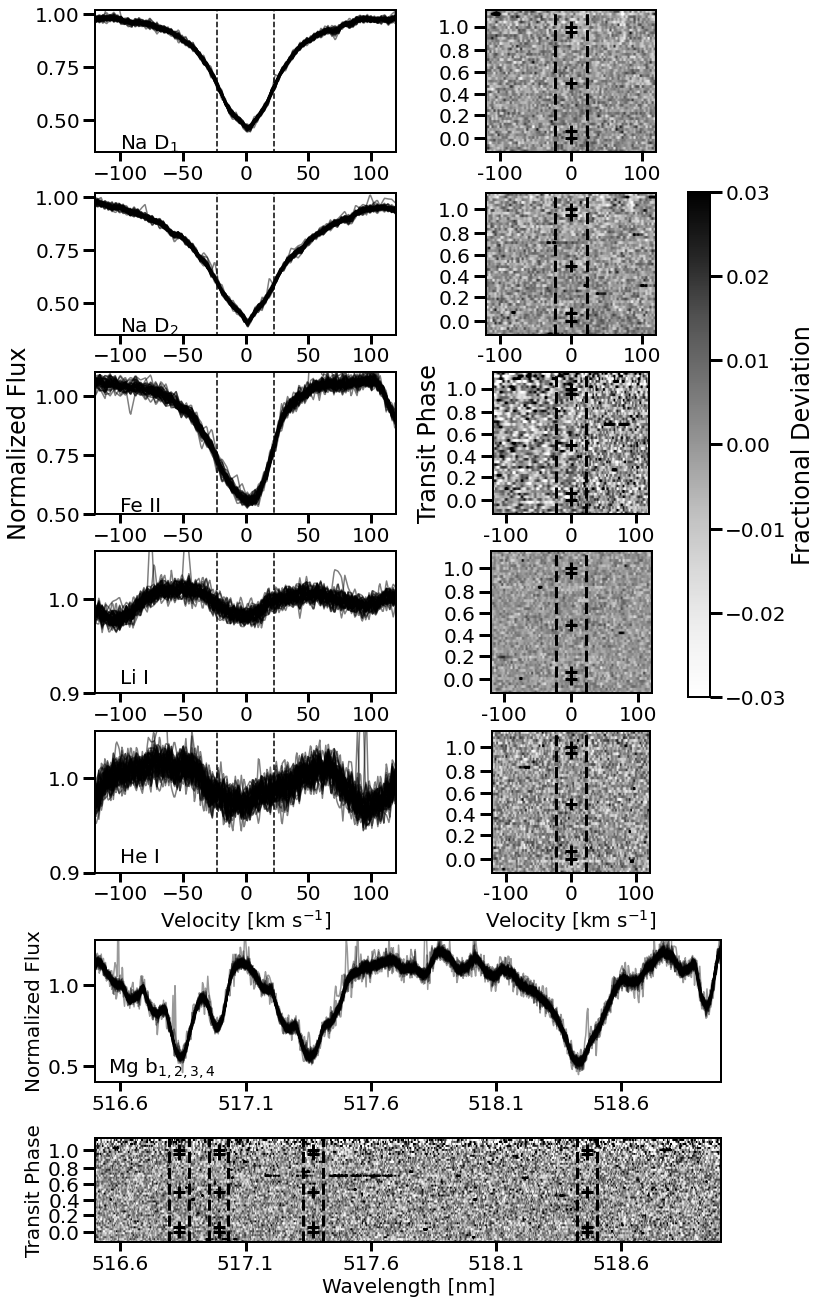

In [64]:
fig2 = plt.figure(constrained_layout=True, figsize=(10, 18))
spec2 = gridspec.GridSpec(ncols=2, nrows=7, figure=fig2)
fig2.set_facecolor('w')

ax1 = fig2.add_subplot(spec2[0, 0])
ax2 = fig2.add_subplot(spec2[1, 0])
ax3 = fig2.add_subplot(spec2[2, 0])
ax4 = fig2.add_subplot(spec2[3, 0])
ax11 = fig2.add_subplot(spec2[4, 0])

ax5 = fig2.add_subplot(spec2[0, 1])
ax6 = fig2.add_subplot(spec2[1, 1])
ax7 = fig2.add_subplot(spec2[2, 1])
ax8 = fig2.add_subplot(spec2[3, 1])
ax12 = fig2.add_subplot(spec2[4, 1])

ax9 = fig2.add_subplot(spec2[5, :])
ax10 = fig2.add_subplot(spec2[6, :])

fig.set_facecolor('w')
cbar_lim = 0.025
keys = ['NaD', 'NaD', 'FeII', 'Li', 'HeI', 'mgb2']
line_plots = [ax1, ax2, ax3, ax4, ax11, ax9]
waterfall = [ax5, ax6, ax7, ax8, ax12, ax10]
text = ['Na D$_{1}$', 'Na D$_{2}$', 'Fe II', 'Li I', 'He I',
        'Mg b$_{1,2,3,4}$']
temp_centers = [589.60, 589.0, 546.38, 679.98,  587.64, 517.4, 516.8,]
ylims = [ [0.35, 1.02], [0.35, 1.02], [0.5, 1.1], [0.9,1.05], [0.9,1.05]]

oot_inds = np.where(np.isnan(yphase)==True)[0]

repeat=6
yticks = np.zeros(len(yphase)*repeat)
z=0
for i in range(len(yphase)):
    yticks[z:z+repeat] = yphase[i]
    z += repeat

for i in range(len(waterfall)):
    
    x = ind_waves[keys[i]] + 0
    y = ind_lines[keys[i]] + 0

    if i < len(waterfall)-1:
        vel, _ = to_velocity(x[0], flux=y[0], line=temp_centers[i])
        for j in range(len(x)):
            line_plots[i].plot(vel, y[j], 'k', alpha=0.5)
        
        line_plots[i].set_xlim(-120,120)
        line_plots[i].vlines(-23,0, 2, color='k', linestyle='--')
        line_plots[i].vlines(23,0, 2, color='k', linestyle='--')
        line_plots[i].set_ylim(ylims[i])
        line_plots[i].text(s=text[i], x=-100, y=ylims[i][0]+0.01)
        
        if i == 2:
            line_plots[i].set_ylabel('Normalized Flux', fontsize=24)
            waterfall[i].set_ylabel('Transit Phase', fontsize=24)
        
        q = ((vel.value>=-120) & (vel.value<=120))
        y_trim = y[:,q]
        
        interpx = interp1d(vel.value[q], np.arange(0,len(y_trim[0]),1))
        
        bins = expanding_bins(y_trim-np.nanmedian(y_trim[oot_inds], axis=0), repeat=repeat)
        waterfall[i].imshow(bins, cmap='Greys', vmin=-0.03, vmax=0.03, origin='lower')
        
        waterfall[i].vlines(interpx(-23),0, 400, color='k', linestyle='--', lw=3)
        waterfall[i].vlines(interpx(23), 0, 400, color='k', linestyle='--', lw=3)
        
        if i == 4:
            waterfall[i].set_xlabel('Velocity [km s$^{-1}$]', fontsize=20)
            line_plots[i].set_xlabel('Velocity [km s$^{-1}$]', fontsize=20)
        waterfall[i].set_xticks([interpx(-100), interpx(0), interpx(100)])
        waterfall[i].set_xticklabels([-100,0,100])
        
        
    else:
        for j in range(len(x)):
            line_plots[i].plot(x[j], y[j], 'k', alpha=0.4)
            
        line_plots[i].set_xlim(516.5,519)
        line_plots[i].set_ylim(0.4,1.28)

        line_plots[i].set_ylabel('Normalized Flux', fontsize=20)
        waterfall[i].set_ylabel('Transit Phase', fontsize=20)
        waterfall[i].set_xlabel('Wavelength [nm]')
        line_plots[i].text(s='Mg b$_{1,2,3,4}$', x=516.55, y=0.45)
        
        q = ((x[0]>=516.5) & (x[0]<=519))
        y_trim = y[:,q]
        
        interpx = interp1d(x[0][q], np.arange(0,len(y_trim[0]),1))
        xticks = np.arange(516.6,518.9,0.5)
        waterfall[i].set_xticks(interpx(xticks))
        waterfall[i].set_xticklabels(xticks)
        line_plots[i].set_xticks(xticks)
        
        bins = expanding_bins(y_trim-np.nanmedian(y_trim[oot_inds], axis=0), repeat=repeat)
        im = waterfall[i].imshow(bins, cmap='Greys', vmin=-0.03, vmax=0.03, origin='lower')
        
        for l in np.array([516.733, 516.891, 517.270, 518.362])+0.1:
            vel, _ = to_velocity(x[0][q], flux=y[0][q], line=l)
            interpv = interp1d(vel.value, np.arange(0,len(y[0][q]),1))
            waterfall[i].vlines(interpv(-23),0, 400, color='k', linestyle='--', lw=3)
            waterfall[i].vlines(interpv(23), 0, 400, color='k', linestyle='--', lw=3)
            
            for p in [0, ingress_phase+0.01, 0.5, egress_phase, 1.0]:
                waterfall[i].plot(interpv(0), interpp(p), '+', ms=12, linewidth=3,
                                  markeredgecolor='k', markeredgewidth=3, zorder=2)
            
    
    waterfall[i].set_ylim(0,len(bins))
    
    interpp = interp1d(yticks, np.arange(0,len(bins),1))
    
    waterfall[i].set_yticks(interpp(np.arange(0,1.2,0.2)))
    waterfall[i].set_yticklabels(np.round(np.arange(0,1.2,0.2),1))
    
    if i < 5:
        for p in [0, 1-egress_phase+0.01, 0.5, egress_phase, 1.0]:
            waterfall[i].plot(interpx(0), interpp(p), '+', ms=12, linewidth=3,
                 markeredgecolor='k', markeredgewidth=3, zorder=2)
    
    waterfall[i].set_rasterized(True)
    line_plots[i].set_rasterized(True)
    
    
cax = fig2.add_axes([0.95, 0.465, 0.03, 0.39])
cbar = fig2.colorbar(im, cax=cax)
cbar.set_label('Fractional Deviation', fontsize=24)

#plt.savefig(os.path.join(plot_dir, 'others_gray_vertical.pdf'),
#            rasterize=True, bbox_inches='tight', dpi=300)

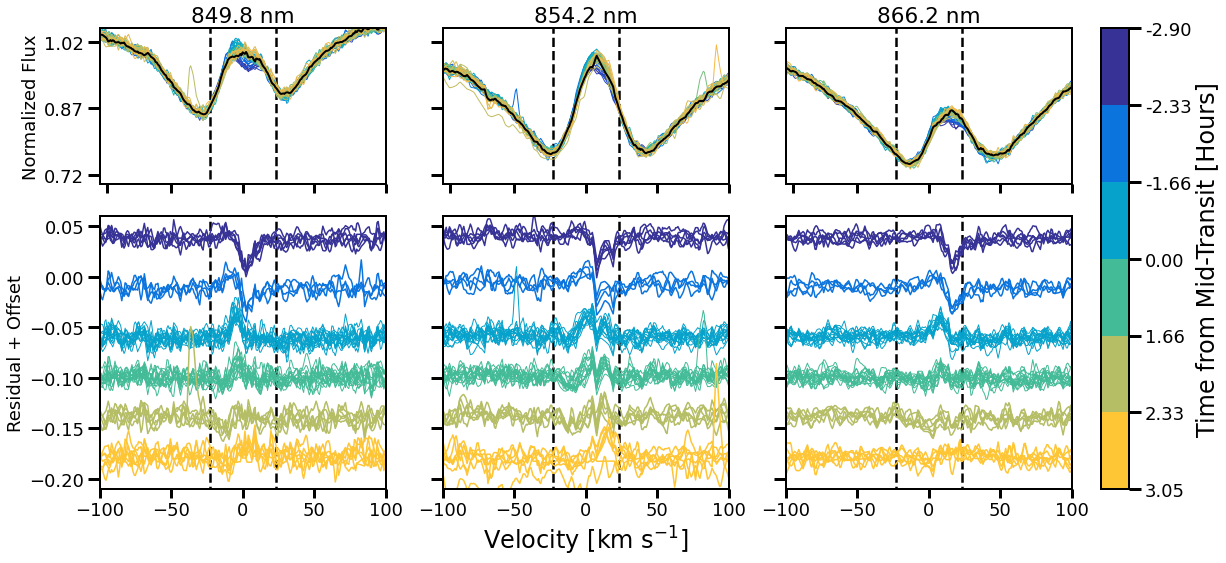

In [141]:
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import BoundaryNorm
plt.rcParams['font.size'] = 18
subkeys = ['caI', 'caII', 'caIII']
fig, ((ax1, ax2, ax3), (ax4, ax5,ax6)) = plt.subplots(nrows=2, ncols=3,
                                                      figsize=(20,8),
                                                      gridspec_kw={'height_ratios':[1,1.75]})
top_row = [ax1, ax2, ax3]
bottom_row = [ax4, ax5,ax6]
fig.set_facecolor('w')
temp_inds = np.where(np.isnan(yphase)==True)[0]

cmap = mpl.colors.ListedColormap(parula_colors)
bounds = [0, 0.25, 0.5, 0.75, 1.0]
int_bound = []
for i in range(len(bounds)):
    if i == 0:
        ind = np.where((np.isnan(yphase[:10])==True))
    else:
        ind = np.where((yphase>=bounds[i-1]) & (yphase < bounds[i]))
    int_bound.append(int(np.nanmedian(ind)*len(bounds)))
    
last_range = np.where(np.isnan(yphase)==True)[0]
last_range = last_range[last_range>10]
int_bound.append( int(np.nanmedian(last_range)*len(bounds)))
#int_bound.append(int_bound[-1]+2)

int_bound = np.linspace(5,220,6, dtype=int)
tm = time_from_mid.value
#ax0.axis('off')

for k, key in enumerate(subkeys):
    template = np.nanmedian(ind_lines[key][temp_inds], axis=0)
    template /= np.nanmedian(template[:20])

    if key == 'caI':
        l = centers[1]
    elif key == 'caII':
        l = centers[2]
    else:
        l = centers[3]
        
    vel, midpoint = to_velocity(ind_waves[key][0], line=l)

    for i in range(len(ind_lines[key])):
        f = ind_lines[key][i] / np.nanmedian(ind_lines[key][i][:20])

        top_row[k].plot(vel, f, c=parula_colors[i*4], lw=1)
        
        if tm[i] <= -2.33:
            bottom_row[k].plot(vel, f-template+0.04, 
                                c=parula_colors[int_bound[0]], lw=1.5)
        elif tm[i]>-2.33 and tm[i]<=-1.66:
             bottom_row[k].plot(vel, f-template-0.01, 
                                c=parula_colors[int_bound[1]], lw=1.5)
        elif tm[i]>-1.66 and tm[i]<=0.0:
             bottom_row[k].plot(vel, f-template-0.06, 
                                c=parula_colors[int_bound[2]], lw=1)
        elif tm[i]>0.0 and tm[i]<=1.66:
             bottom_row[k].plot(vel, f-template-0.10, 
                                c=parula_colors[int_bound[3]], lw=1)
        elif tm[i]>1.66 and tm[i]<=2.33:
            bottom_row[k].plot(vel, f-template-0.14, 
                               c=parula_colors[int_bound[4]], lw=1.5)
        else:
            bottom_row[k].plot(vel, f-template-0.18, 
                               c=parula_colors[int_bound[5]], lw=1.5)
            
    top_row[k].plot(vel, template, COLOR, lw=2)
    
    bottom_row[k].set_xlim(-100,100)
    top_row[k].set_xlim(-100,100)
    
    if k == 0:
        top_row[k].set_title('849.8 nm')
    elif k == 2:
        top_row[k].set_title('866.2 nm')

    top_row[k].set_xticks([-95, -50, 0, 50, 100])
    bottom_row[k].set_xticks([-100, -50, 0, 50, 100])
    
    top_row[k].set_xticklabels([])
    
    top_row[k].vlines(23, -10, 10, color=COLOR, linestyle='--', lw=2.5)
    top_row[k].vlines(-23, -10, 10, color=COLOR, linestyle='--', lw=2.5)
    
    bottom_row[k].vlines(23, -10, 10, color=COLOR, linestyle='--', lw=2.5)
    bottom_row[k].vlines(-23, -10, 10, color=COLOR, linestyle='--', lw=2.5)
    
    if k > 0:
        top_row[k].set_yticklabels([])
        bottom_row[k].set_yticklabels([])
    top_row[k].set_ylim(0.7,1.05)
    top_row[k].set_yticks(np.round(np.linspace(0.72,1.02,3),2))
    bottom_row[k].set_ylim(-0.21,0.06)
    
    if k == 1:
        bottom_row[k].set_xlabel('Velocity [km s$^{-1}$]', fontsize=24)
        top_row[k].set_title('854.2 nm')
bottom_row[0].set_ylabel('Residual + Offset')
top_row[0].set_ylabel('Normalized Flux')

cmap = mpl.colors.ListedColormap(np.flip(parula_colors[int_bound]))
#norm = BoundaryNorm(int_bound, cmap.N)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.82, 0.1, 0.02, 0.8])

cbar = ColorbarBase(cax, cmap=cmap)#, 
                    #norm=norm)
cbarticks = np.linspace(0,1,7)
cbar.set_ticks(cbarticks)
cbar.set_ticklabels(np.flip(['-2.90', '-2.33', '-1.66', 
                                      '0.00', '1.66', '2.33', '3.05']))
cbar.set_label('Time from Mid-Transit [Hours]', fontsize=24)
plt.subplots_adjust(hspace=0.15, wspace=0.2)
#plt.colorbar(cax=cax)


#plt.savefig(os.path.join('/Users/arcticfox/Documents/atmospheres/v1298tau/figures/',
#                         'calcium_triplet.pdf'), 
#            rasterize=True, bbox_inches='tight', dpi=250)

#plt.savefig(os.path.join(github_dir,
#                         'calcium_triplet.png'), 
#            rasterize=True, bbox_inches='tight', dpi=250, transparent=True)

# Feature light curves

In [68]:
pieces = {}
keys = np.array(list(ind_waves.keys()))
keys = np.append(keys[:7], keys[9])
for l, key in enumerate(keys):

    if l == 7:
        l += 2
    params = subregions(centers[l], 
                        wavelengths[key][0],
                        offsets[l], 
                        line_offsets[l], 
                        feature=key)

    cont_split = int(np.where(np.diff(params['continuum']) > 1)[0][0])

    red = params['continuum'][cont_split+1:]
    blue = params['continuum'][:cont_split]
    

    for i in range(len(wavelengths[key])):
        
        if i == 0:
            f = np.zeros((len(wavelengths[key]), 
                         len(spectra[key][i][params['region']][params['line']])))
            r = np.zeros((len(wavelengths[key]), len(spectra[key][i][red])))
            b = np.zeros((len(wavelengths[key]), len(spectra[key][i][blue])))
            w = np.zeros((len(wavelengths[key]), 
                         len(interp_std[key][i][params['region']][params['line']])))
            c = np.zeros((len(wavelengths[key]), 
                         len(spectra[key][i][params['region']])))
            cw= np.zeros((len(wavelengths[key]), 
                         len(spectra[key][i][params['region']])))
            
        f[i] = spectra[key][i][params['region']][params['line']]+0.0
        w[i] = interp_std[key][i][params['region']][params['line']]*2
        
        c[i] = spectra[key][i][params['region']]+0.0
        cw[i]= interp_std[key][i][params['region']]*2
        
        r[i] = spectra[key][i][red] + 0.0
        b[i] = spectra[key][i][blue]+ 0.0
    
    if key != 'NaD':
        pieces[key] = [f, w, r, b]
    elif key == 'NaD':
        key1, key2 = 'NaD1', 'NaD2'
        reg1 = np.arange(65,450,1,dtype=int)
        reg2 = np.arange(600,len(f[0]),1,dtype=int)
        pieces[key1] = [f[:,reg1], w[:,reg1], r[:,reg1], b[:,reg1]]
        pieces[key2] = [f[:,reg2], w[:,reg2], r[:,reg2], b[:,reg2]]
        
    if key == 'caI': #or key=='caIII' or key=='caII':
        int1 = [0, 100]
        int2 = [350, 447]

    if key == 'caII':
        int1 = [0,150]
        int2 = [700, 823]
        
    if key == 'caIII':
        int1 = [0,200]
        int2 = [650,822]
        reg = np.append(np.arange(int1[0], int1[-1], 1, dtype=int),
                        np.arange(int2[0], int2[-1], 1, dtype=int))

        print(f.shape)
        
    if key == 'caI' or key=='caIII' or key=='caII':
        newk = key+'_cont'
        reg = np.append(np.arange(int1[0], int1[-1], 1, dtype=int),
                        np.arange(int2[0], int2[-1], 1, dtype=int))
        #print(spectra[key][i][params['region']][reg], reg)
        pieces[newk] = [c[:,reg],
                        cw[:,reg], 
                        0, 0]#r[:,reg], b[:,reg]]

(53, 343)


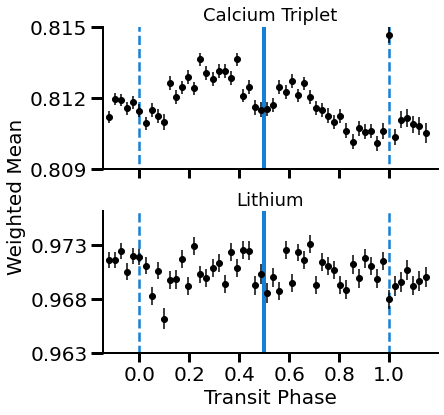

In [69]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6,6),
                               sharex=True)

interp = interp1d(yphase, np.arange(0,len(yphase),1))

for phase in [0, 0.5, 1]:
    if phase != 0.5:
        linestyle='--'
        lw=2.5
    else:
        linestyle='-'
        lw=4
    ax1.vlines(interp(phase), -10, 10, lw=lw,
               color=parula_colors[60], linestyle=linestyle)
    ax2.vlines(interp(phase), -10, 10, lw=lw,
               color=parula_colors[60], linestyle=linestyle)

num, denom = 0, 0
cont, err = 0, 0

key = 'Li'
num = np.nansum(np.array(pieces[key][0]) / np.array(pieces[key][1]**2), axis=1)
denom = np.nansum( 1.0 / np.array(pieces[key][1]**2), axis=1)
err = np.sqrt( 1.0 / np.nansum(pieces[key][1]**-2, axis=1))

#cont = np.nanmean(np.array(pieces[key][2]), axis=1)
#cont += np.nanmean(np.array(pieces[key][3]), axis=1)

flux1 = (num/denom)#/cont
#flux1 /= np.nanmedian(flux1)

#err = np.sqrt(1/np.nansum(interp_variances['Li']**2, axis=1))

if COLOR == 'white':
    ax2.errorbar(np.arange(0,len(flux1),1), 
                 flux1, yerr=err,
                 color=ACCENT_COLOR, #yerr=err, 
                 fmt='o')
else:
    ax2.errorbar(np.arange(0,len(flux1),1), 
                 flux1, yerr=err,
                 color=COLOR, #yerr=err, 
                 fmt='o')   

ax2.set_title('Lithium', fontsize=18)
ax2.set_ylim(np.nanmin(flux1)-0.003, np.nanmax(flux1)+0.003)
ax2.set_yticks(np.round(np.arange(np.nanmin(flux1)-0.003, np.nanmax(flux1)+0.003,0.005),3))

canum, cadenom = 0, 0
cont, caerr = 0, 0

for key in ['caI', 'caII', 'caIII']:
    canum   += np.nansum(np.array(pieces[key][0]) / np.array(pieces[key][1]**2), axis=1)
    cadenom += np.nansum( 1.0 / np.array(pieces[key][1]**2), axis=1)
    caerr   += np.nansum(pieces[key][1]**-2, axis=1) 
    
caerr = np.sqrt(1.0/caerr)

flux2 = (canum/cadenom)

if COLOR == 'white':
    ax1.errorbar(np.arange(0,len(flux2),1), 
                 flux2, 
                 yerr=caerr,
                 color=ACCENT_COLOR, #yerr=err, 
                 fmt='o')
else:
    ax1.errorbar(np.arange(0,len(flux2),1), 
                 flux2, 
                 yerr=caerr,
                 color=COLOR, #yerr=err, 
                 fmt='o')
    
ax1.set_ylim(np.nanmin(flux2)-0.001, np.nanmax(flux2))
ax1.set_yticks(np.round(np.arange(np.nanmin(flux2)-0.001, np.nanmax(flux2)+0.002,0.003),3))
ax1.set_title('Calcium Triplet', fontsize=18)

ax2.set_xlabel('Transit Phase')
ax2.set_ylabel('Weighted Mean', y=1.1, x=-0.4)
    

ax2.set_xticks(interp(np.arange(0,1.2,0.2)))
ax2.set_xticklabels(np.round(np.arange(0,1.2,0.2),2))
ax2.set_xlim(-1, len(yphase)+1)

plt.subplots_adjust(hspace=0.3)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

#plt.savefig(os.path.join(plot_dir, 'weighted_means.pdf'),
#            rasterize=True, bbox_inches='tight', dpi=250)
#
#plt.savefig(os.path.join(github_dir, 'weighted_means.png'),
#            rasterize=True, bbox_inches='tight', dpi=250, transparent=True)

In [70]:
def weighted_means(keys):
    
    canum, cadenom = 0, 0
    cont, caerr = 0, 0

    for key in keys:
        canum   += np.nansum(np.array(pieces[key][0]) / np.array(pieces[key][1]**2), axis=1)
        cadenom += np.nansum( 1.0 / np.array(pieces[key][1]**2), axis=1)
        caerr   += np.nansum(pieces[key][1]**-2, axis=1) 

    err = np.sqrt(1.0/caerr)
    flux = (canum/cadenom)
    
    return flux, err

In [71]:
def plot_weighted_mean(key, ax, title):
    global phi
    f, e = weighted_means(key)
    ax.errorbar(np.arange(0,len(f),1), 
                 f, yerr=e*2,
                 color=COLOR, 
                 fmt='o')   
    
    if title != '(b) Ca II Triplet':
        ax.set_ylim(np.nanmin(f)-0.002, np.nanmax(f)+0.002)
        ax.set_yticks(np.round(np.linspace(np.nanmin(f)-0.001, np.nanmax(f)+0.001,3),3))
    else:
        ax.set_ylim(0.809, 0.815)
        ax.set_yticks(np.round(np.linspace(0.809, 0.815,3),3))
    ax.set_title(title, fontsize=18)
    
    ax2 = ax.twinx()
    
    val = spearmanr(phi, f).correlation
    ax2.set_ylabel(r'$\rho$ = {0}'.format("%0.2f"%np.round(val,2)))
    ax2.set_yticks([])
    
    return f, e

In [72]:
period = 8.24958*units.day

star_rv = 14.427 #* units.km/units.s
kp = 0.02*units.km/units.s # from proposal estimate

T0 = Time(planet_c_t0, format='jd').mjd+3*period.value
phi = (TIME.value-T0)/period.value

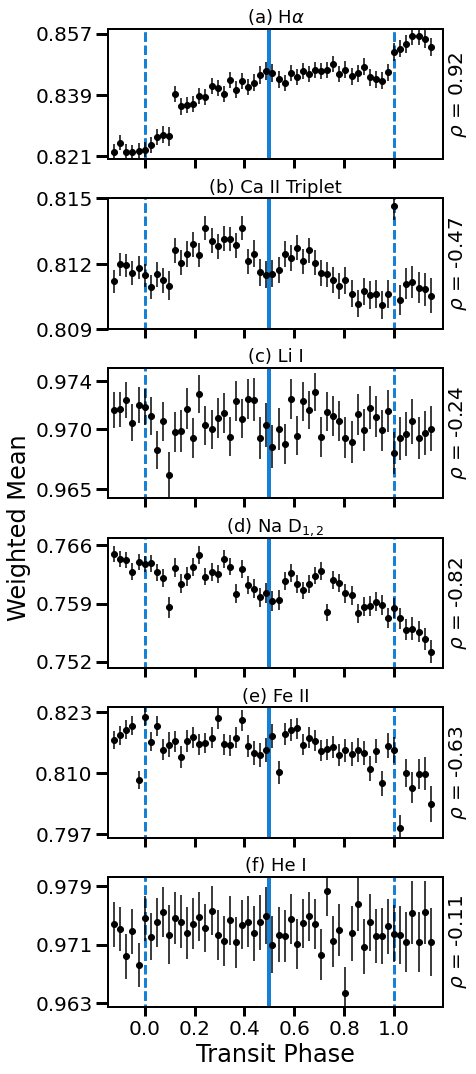

In [73]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, 
                                                   figsize=(6,18),
                                                   sharex=True)
fig.set_facecolor('white')
interp = interp1d(yphase, np.arange(0,len(yphase),1))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for phase in [0, 0.5, 1]:
    if phase != 0.5:
        linestyle='--'
        lw=2.5
    else:
        linestyle='-'
        lw=4
    for ax in axes:
        ax.vlines(interp(phase), -10, 10, lw=lw,
                   color=parula_colors[60], linestyle=linestyle)
        ax.vlines(interp(phase), -10, 10, lw=lw,
                   color=parula_colors[60], linestyle=linestyle)
        ax.vlines(interp(phase), -10, 10, lw=lw,
                   color=parula_colors[60], linestyle=linestyle)

f_ha, _ = plot_weighted_mean(['halpha'], ax1, r'(a) H$\alpha$')
f_ca, _ = plot_weighted_mean(['caI', 'caII', 'caIII'], ax2, '(b) Ca II Triplet')
f_li, _ = plot_weighted_mean(['Li'], ax3, '(c) Li I')
f_na, _ = plot_weighted_mean(['NaD1', 'NaD2'], ax4, '(d) Na D$_{1,2}$')
f_fe, _ = plot_weighted_mean(['FeII'], ax5, '(e) Fe II')
f_he, e = plot_weighted_mean(['HeI'], ax6, '(f) He I')


ax6.set_xlabel('Transit Phase', fontsize=24)
ax4.set_ylabel('Weighted Mean', y=1.08, fontsize=24)
    

ax2.set_xticks(interp(np.arange(0,1.2,0.2)))
ax2.set_xticklabels(np.round(np.arange(0,1.2,0.2),2))
ax2.set_xlim(-1, len(yphase)+1)

plt.subplots_adjust(hspace=0.3)

#plt.savefig(os.path.join(plot_dir, 'weighted_means.pdf'),
#            rasterize=True, bbox_inches='tight', dpi=250)
#
#plt.savefig(os.path.join(github_dir, 'weighted_means.png'),
#            rasterize=True, bbox_inches='tight', dpi=250, transparent=True)

In [74]:
sets = [['halpha'], ['caI', 'caII', 'caIII'], ['Li'], ['NaD1', 'NaD2'],
        ['FeII'], ['HeI']]
lin_removed = []

for i in range(len(sets)):
    f, e = weighted_means(sets[i])
    inds = np.append(np.arange(0,15,1,dtype=int),
                     np.arange(53-15,53,1,dtype=int))
    p = np.polyfit(phi, f, deg=1)
    fit = np.poly1d(p)
    lin_removed.append(f-fit(phi))

In [75]:
grid = np.zeros((len(sets), len(sets)))
for i in range(len(sets)):
    inds = np.arange(0,len(sets),1,dtype=int)
    inds = np.delete(inds, i)
    spr = []
    for n in inds:
        grid[i][n] = spearmanr(lin_removed[i], lin_removed[n]).correlation
    grid[i][i] = np.nan

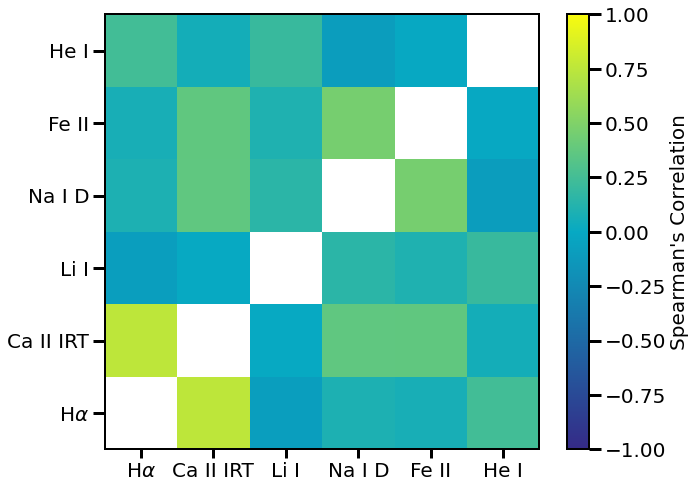

In [77]:
clist = np.array(['#D66A14', '#FFFFFF', parula_colors[60]])
clist = np.array([parula_colors[0], parula_colors[100], parula_colors[-1]])
rgb_tuples = []

for c in clist:
    rgb_tuples.append(hex_to_rgb(c))

cmnew = LinearSegmentedColormap.from_list(
        'sequential', rgb_tuples, N=2048)

fig = plt.figure(figsize=(10,8))
fig.set_facecolor('w')
plt.imshow(grid, vmin=-1.0, vmax=1.0, cmap=cmnew, origin='lower')
plt.colorbar(label="Spearman's Correlation")
labels = [r'H$\alpha$', 'Ca II IRT', 'Li I', 'Na I D', 'Fe II', 'He I']
plt.xticks(np.arange(0,6,1), labels=labels)
plt.yticks(np.arange(0,6,1), labels=labels);
#plt.savefig(os.path.join(plot_dir, 'spearmans.pdf'), dpi=250, rasterize=True,
#            bbox_inches='tight')

## Difference Curves

In [78]:
keys = ['caI', 'caII', 'caIII']
contkeys = ['caI_cont', 'caII_cont', 'caIII_cont']
sum_core = np.zeros((3,53))
sum_cont = np.zeros((3,53))

for i in range(len(keys)):
    f, _ = weighted_means([keys[i]])
    fc, _= weighted_means([contkeys[i]])
    sum_cont[i] = fc
    sum_core[i] = f

In [443]:
hrtime = ((TIME.value*units.day-TIME.value[0]*units.day)).to(units.hour)

In [444]:
np.save('calcium.npy', [hrtime.value, flux2, err, yphase])

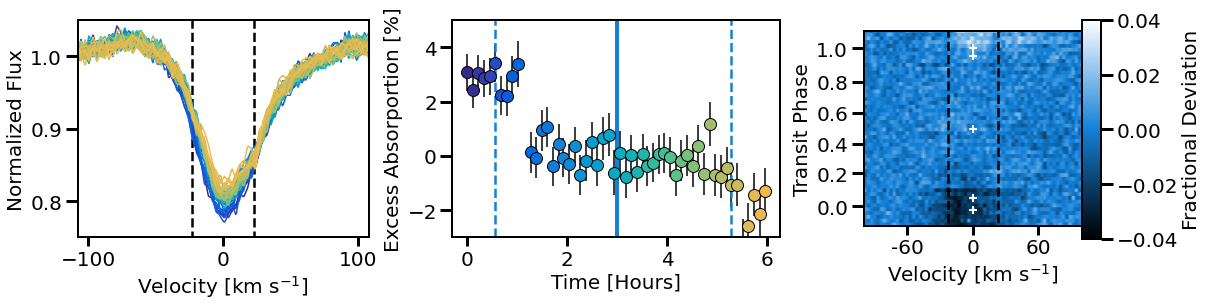

In [101]:
nw, ns = mask_lines(ind_waves['halpha'], ind_lines['halpha'], std=3, offset=0.05)#,
                    #template_inds=np.where(np.isnan(yphase)==True)[0])

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,4),
                                    gridspec_kw={'width_ratios':[2,2.25,1.5]})

time_hours = (TIME.value*units.day-np.nanmin(TIME.value)*units.day).to(units.hour)

vel, midpoint = to_velocity(nw[0], line=centers[0])
vel = vel.value

err = np.nansum(interp_std['halpha']**2, axis=1)

for i in range(len(ns)):
    ax1.plot(vel, ns[i]/np.nanmedian(ns[i]),  c=parula_colors[i*4])
    ax2.errorbar(time_hours.value[i], widths['halpha'][i], 
                 yerr=np.sqrt(err[i]),
                 marker='o', ms=12, ecolor='k',
                 c=parula_colors[i*4],
                 markeredgecolor='k')

    
ax1.vlines(23, -100, 1000,
           color='k', linestyle='--', lw=2.5)
ax1.vlines(-23, -100, 1000,
           color='k', linestyle='--', lw=2.5)


interp = interp1d(yphase, time_hours.value)


ax2.vlines(interp(0), -100,100,
           color=parula_colors[60], linestyle='--', lw=2.5)
ax2.vlines(interp(1), -100,100, 
           color=parula_colors[60], linestyle='--', lw=2.5)
ax2.vlines(interp(0.5), -100,100, 
           color=parula_colors[60], linestyle='-', lw=4)


ax2.set_ylim(-3,5)

ax1.set_xlabel('Velocity [km s$^{-1}$]')
ax1.set_ylim(0.75,1.05)
ax1.set_xlim(-108,108)
ax1.set_ylabel('Normalized Flux')


ax2.set_ylabel('Excess Absorportion [%]')
ax2.set_xlabel('Time [Hours]')

repeat=6
bins = expanding_bins(ind_lines['halpha'], repeat=repeat)
im = ax3.imshow(bins, cmap=cm, vmin=-0.04, vmax=0.04)

repeat_yphase = np.zeros(len(yphase)*repeat)

z = 0
for i in range(len(yphase)):
    repeat_yphase[z:z+repeat] = yphase[i]
    z += repeat

interp = interp1d(repeat_yphase, np.arange(0,len(repeat_yphase),1))
yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax3.set_yticks(interp(yticks))
ax3.set_yticklabels(yticks)

interp_vel = interp1d(vel, np.arange(0,len(vel),1))

xticks = [interp_vel(-60), interp_vel(0), interp_vel(60)]
ax3.set_xticks(xticks)
ax3.set_xticklabels([-60,0,60])

for p in [0, ingress_phase, 0.5, egress_phase, 1]:
    if p == 0:
        ax3.plot(interp_vel(0), interp(p)-repeat, 'w+', ms=8, linewidth=2,
                 markeredgecolor='w', markeredgewidth=2)
    else:
        ax3.plot(interp_vel(0), interp(p), 'w+', ms=8, linewidth=2,
                 markeredgecolor='w', markeredgewidth=2)


ax3.vlines(np.where(vel>=23)[0][0], -100, 1000,
           color='k', linestyle='--', lw=2.5)
ax3.vlines(np.where(vel>=-23)[0][0], -100, 1000,
           color='k', linestyle='--', lw=2.5)
#ax3.hlines(interp(0.5), -100, 1000, color='w',
#           linestyle='--', lw=2.5)


ax3.set_ylim(0,len(bins)-10)
ax3.set_xlim(interp_vel(-100), interp_vel(100))
ax3.set_ylabel('Transit Phase', fontsize=20)
ax3.set_xlabel('Velocity [km s$^{-1}$]', fontsize=20)

cax = fig.add_axes([0.9, 0.12, 0.015, 0.76])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('Fractional Deviation')

plt.subplots_adjust(wspace=0.3)
#plt.savefig(os.path.join(plot_dir, 'halpha.pdf'),
#            dpi=250, rasterize=True,
#            bbox_inches='tight')


1.4501955143613205

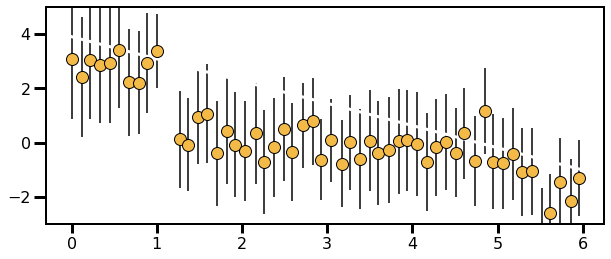

In [106]:
plt.figure(figsize=(10,4))

q = (((time_hours.value <= 0.6) & (time_hours.value>0.5)) 
     | ((time_hours.value > 4.8) & (time_hours.value<5.2) ))
fit = np.polyfit(time_hours.value[q], widths['halpha'][q], 1)
model = np.poly1d(fit)

plt.errorbar(time_hours.value, widths['halpha'], 
                 yerr=err, linestyle='',
                 marker='o', ms=12, ecolor='k',
                 c=parula_colors[i*4],
                 markeredgecolor='k')
plt.plot(time_hours.value, model(time_hours.value), 'w', lw=3)

plt.ylim(-3,5)
model(3)

# Putting in context

In [111]:
rs = 1.18 * units.Rsun
rp = 0.038*rs

atm_height = np.sqrt(0.05 * rs**2).to(units.Rjup) # = rp**2/rs**2
atm_tail   = (2.5/5.59 * rs).to(units.Rjup)

In [112]:
atm_height, atm_tail

(<Quantity 2.56762483 jupiterRad>, <Quantity 5.13540577 jupiterRad>)

## Shift to Planet Rest Frame

In [114]:
# assuming planet mass of 10 MEarth
period = 8.24958*units.day
rstar = 1.345*units.Rsun
#kp = rv_signal(1.101*units.Msun, period, 25*units.Mearth, 88.49)

star_rv = 14.427 #* units.km/units.s
kp = 0.02*units.km/units.s # from proposal estimate

T0 = Time(planet_c_t0, format='jd').mjd+3*period.value
phi = (TIME-T0)/period

kp = (2 * np.pi * 13.19*rstar) / period
kp = kp.to(units.km/units.s)

pl_offset = kp * np.sin(2*np.pi*phi.value)
pl_offset = pl_offset.value

kp, pl_offset[-1]-pl_offset[0]

(<Quantity 108.79861596 km / s>, 20.519921941827786)

In [115]:
from matplotlib.colors import LinearSegmentedColormap

clist = np.array(['#000000', parula_colors[160], '#FFFFFF',
                  
                  ])
rgb_tuples = []

for c in clist:
    rgb_tuples.append(hex_to_rgb(c))

cm1 = LinearSegmentedColormap.from_list(
        'sequential', rgb_tuples, N=2048)

### (1 - ratio of the lines_in/lines_out) --> absorption = up
- stellar rest frame
- construct oot template/total median in stellar rest frame
- divide all spectra by oot template
- shift to planet rest frame 
- you wouldn't get emission since the planet is backlit in transit

-158.58347327142576 172.60220676812577
-304.51900134051664 305.8702547768709
-306.96750504034276 293.90986581321124
-120.9731365120373 108.22965554288041


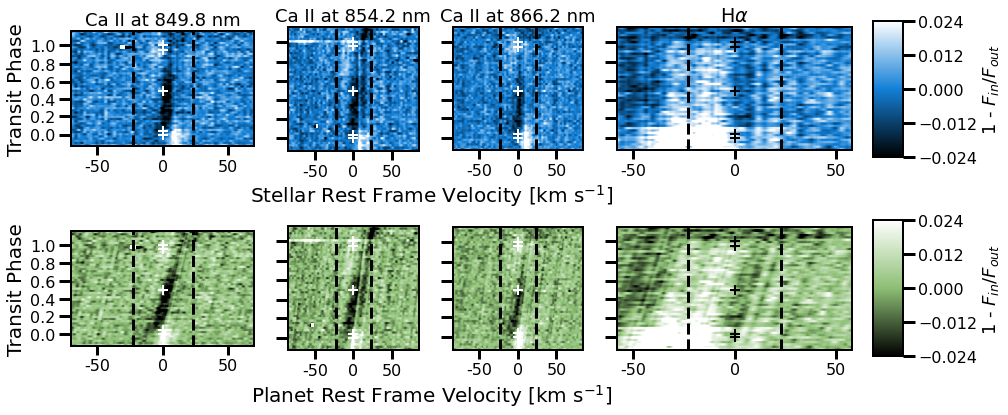

In [116]:
totallen = 1000
pl_vel_grid, pl_grid = np.zeros((3, totallen)), np.zeros((3, len(specfiles), totallen))

fig, ((ax1, ax2, ax3, ax7), (ax4, ax5, ax6, ax8)) = plt.subplots(ncols=4, nrows=2,
                                                       figsize=(14,7), sharey=True,
                                                                 gridspec_kw=
                                                                 {'width_ratios':[1.4,1,1,1.8]})
#fig.set_facecolor('w')
top = [ax1, ax2, ax3, ax7]
bot = [ax4, ax5, ax6, ax8]

repeat=5

for x, key in enumerate(['caI', 'caII', 'caIII', 'halpha']):
    nw, ns = mask_lines(ind_waves[key], ind_lines[key], 
                        std=10, offset=0.01)#,
                        #template_inds=np.arange(47,53,1,dtype=int))
    
    if key == 'caI':
        l = centers[1]-0.02
    elif key == 'caII':
        l = centers[2]
    elif key == 'caIII':
        l = centers[3]+0.02
    else:
        l = centers[0]+0.04

    vel, _ = to_velocity(nw[0], line=l)
    
    template = np.nanmedian(ns[np.isnan(yphase)==True], axis=0)

    bins = expanding_bins(1-(ns/template), subtract=False, repeat=repeat)
    z = 0
    repeat_yphase = np.zeros(len(yphase)*repeat)
    for i in range(len(yphase)):
        repeat_yphase[z:z+repeat] = yphase[i]
        z += repeat

    temp = np.zeros((len(ns), len(ns[0])))

    
    for i in range(len(ns)):
        newv = vel.value+pl_offset[i]+0.0
        temp[i] = newv+0.0

    total_vel = np.linspace(np.nanmax(np.nanmin(temp, axis=1)), 
                            np.nanmin(np.nanmax(temp, axis=1)), totallen)
    
    pl_grid = np.zeros((len(ns), totallen))
    st_grid = np.zeros((len(ns), totallen))
    
    
    for i in range(len(ns)):
        interp = interp1d(vel.value+pl_offset[i], 1-(ns[i]/template))
        pl_grid[i] = interp(total_vel)
        interp = interp1d(vel.value, 1-(ns[i]/template))
        st_grid[i] = interp(total_vel)
    
    if x == 0:
        top[x].set_ylabel('Transit Phase', fontsize=20)
        bot[x].set_ylabel('Transit Phase', fontsize=20)
        top[x].set_title('Ca II at 849.8 nm', fontsize=18)
    elif x == 1:
        top[x].set_title('Ca II at 854.2 nm', fontsize=18)
        top[x].set_xlabel('Stellar Rest Frame Velocity [km s$^{-1}$]', x=1.1,
                          fontsize=20)
        bot[x].set_xlabel('Planet Rest Frame Velocity [km s$^{-1}$]', x=1.1, 
                          fontsize=20)
    elif x == 2:
        top[x].set_title('Ca II at 866.2 nm', fontsize=18)
    else:
        top[x].set_title(r'H$\alpha$')
    
    if x == 0:
        q = ((total_vel>=-70) & (total_vel<=70))
    elif x > 0 and x < 3:
        q = ((total_vel>=-85) & (total_vel<=85))
    else:
        q = ((total_vel>=-58) & (total_vel<=58))

    cbarlim = 0.024
    
    im1 = top[x].imshow(expanding_bins(st_grid[:,q], subtract=False, repeat=repeat),
                  origin='lower', cmap=cm,#.reversed(),
                  vmin=-cbarlim, vmax=cbarlim)
    
    im2 = bot[x].imshow(expanding_bins(pl_grid[:,q], subtract=False, repeat=repeat), 
                  origin='lower', cmap=cm1,#.reversed(),
                  vmin=-cbarlim, vmax=cbarlim)
    
    xticks = [-50, 0, 50]
    
    xinterp = interp1d(total_vel[q], np.arange(0,len(pl_grid[2,q]),1))
    bot[x].set_xticks(xinterp(xticks))
    bot[x].set_xticklabels(xticks)

    bot[x].vlines(xinterp(-23), 0, 500, color='k', linestyle='--', lw=3, zorder=2)
    bot[x].vlines(xinterp(23), 0, 500, color='k', linestyle='--', lw=3, zorder=2)
    top[x].set_xticks(xinterp(xticks))
    top[x].set_xticklabels(xticks)
    top[x].vlines(xinterp(-23), 0, 500, color='k', linestyle='--', lw=3, zorder=2)
    top[x].vlines(xinterp(23), 0, 500, color='k', linestyle='--', lw=3, zorder=2)

    yinterp = interp1d(repeat_yphase, np.arange(0,len(repeat_yphase),1))
    if x < 3:
        pluscolor = 'w'
    else:
        pluscolor = 'k'
    for p in [0, ingress_phase, 0.5, egress_phase, 1]:
        top[x].plot(xinterp(0), yinterp(p), '+', ms=10, linewidth=2,
                 markeredgecolor=pluscolor, markeredgewidth=2, zorder=2)
        bot[x].plot(xinterp(0), yinterp(p), '+', ms=10, linewidth=2,
                 markeredgecolor=pluscolor, markeredgewidth=2, zorder=2)
    yticks = np.round(np.arange(0,1.2,0.2),1)
    top[x].set_yticks(yinterp(yticks))
    top[x].set_yticklabels(yticks)
    bot[x].set_yticks(yinterp(yticks))
    bot[x].set_yticklabels(yticks)
    
    bot[x].set_ylim(0,len(TIME)*repeat)
    top[x].set_ylim(0,len(TIME)*repeat)
    
    top[x].set_rasterized(True)
    bot[x].set_rasterized(True)
    print(total_vel[0], total_vel[-1])
    
cax1 = fig.add_axes([0.92, 0.565, 0.03, 0.27])
cbar1 = fig.colorbar(im1, cax=cax1)
cbar1.set_label('1 - $F_{in}/F_{out}$', fontsize=18)
cbar1.set_ticks(np.round(np.linspace(-cbarlim, cbarlim, 5),3))

cax2 = fig.add_axes([0.92, 0.17, 0.03, 0.27])
cbar2 = fig.colorbar(im2, cax=cax2)
cbar2.set_label('1 - $F_{in}/F_{out}$', fontsize=18)
cbar2.set_ticks(np.round(np.linspace(-cbarlim, cbarlim, 5),3))

plt.subplots_adjust(hspace=0.1)
#plt.savefig(os.path.join(github_dir,'planet_restframe.png'), dpi=350,
#            rasterize=True, bbox_inches='tight')
#plt.savefig(os.path.join(plot_dir,'planet_restframe.pdf'), dpi=350,
#            rasterize=True, bbox_inches='tight')

## Misttborn files

In [112]:
import pickle

In [119]:
key = 'caI'
output_dict = {}
output_dict['ttime'] = Time(TIME, format='mjd').mjd
output_dict['texptime'] = np.full(len(TIME), 360.0)
vel = to_velocity(ind_waves[key][0], line=centers[1])
output_dict['vabsfine'] = vel[0].value
output_dict['profarr'] = ind_lines[key][:,1:]
output_dict['avgprof'] = np.nanmedian(ind_lines[key][np.isnan(yphase)==True], axis=0)[1:]
output_dict['profarrerr'] = interp_std[key][:,all_params[key]['region']]
output_dict['avgproferr'] = np.nanmean(interp_std[key][:,all_params[key]['region']][np.isnan(yphase)==True], axis=0)/np.sqrt(len(TIME))
output_dict['whichplanet'] = 1

pkl_dir = '/Users/arcticfox/Documents/atmospheres/v1298tau/misttborn'
with open(os.path.join(pkl_dir,'v1298_{0}.pkl'.format(key)), 'wb') as f:
    pickle.dump(output_dict, f)

In [130]:
nw, ns = mask_lines(ind_waves['halpha'], ind_lines['halpha'], 
                        std=10, offset=0.01)